# Bayesian Linear Mixed-Effects Regression
## Computational Methods in Psychology (and Neuroscience)
### Psychology 4215/7215 --- Fall 2021
By: Per B. Sederberg, PhD



# Lesson Objectives

Upon completion of this lesson, students should have learned:

1. Quick ANOVA example
2. Introduction to mixed-effects models
3. Introduction to Bayesian models
4. Fit and visualize a Bayesian mixed-effects regression to our data


# New libraries to install

You're going to need new Bayesian modeling and plotting libraries, so run these lines at your Anaconda Prompt/Terminal:

```bash
conda install -c conda-forge arviz
conda install -c conda-forge patsy pymc3 pystan
conda install -c conda-forge bambi
pip install scikit-misc
```


In [1]:
# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
import plotnine as pn
import scipy.stats.distributions as dists     # probability distributions
from scipy import stats
from glob import glob
import os
import arviz as az
import bambi as bmb
import statsmodels.formula.api as smf
import statsmodels.api as sm

from smile.log import log2dl

from ci_within import ci_within

## Custom SLOG loading function

In [2]:
# custom function to load slogs
def load_all_subj_logs(data_dir, log_file):
    # load in a list of all the subj
    subjs = [os.path.splitext(os.path.split(filepath)[1])[0].split('_')[0]
             for filepath in glob(os.path.join(data_dir, '*' + log_file + '.slog'))]
    subjs.sort()
    #print(subjs)
    # loop over subj and their data
    all_dat = []
    for subj in subjs:
        # set the file
        log_path = os.path.join(data_dir, subj+'_'+log_file+'.slog')
        print(log_path)

        # load the data
        try:
            all_dat.extend(log2dl(log_path, subj=subj))
        except:
            pass

    df = pd.DataFrame(all_dat)
    
    return df

## Load in all the data

In [3]:
data_dir = 'recog_dat'
df_w = load_all_subj_logs(data_dir, 'log_word_test')
df_w.head()

recog_dat/s000_log_word_test.slog
recog_dat/s001_log_word_test.slog
recog_dat/s002_log_word_test.slog
recog_dat/s003_log_word_test.slog
recog_dat/s004_log_word_test.slog
recog_dat/s005_log_word_test.slog
recog_dat/s006_log_word_test.slog
recog_dat/s007_log_word_test.slog
recog_dat/s008_log_word_test.slog
recog_dat/s009_log_word_test.slog
recog_dat/s010_log_word_test.slog
recog_dat/s011_log_word_test.slog
recog_dat/s012_log_word_test.slog


,resp_map_target,resp_map_lure,block_num,trial_num,stim_on_time,stim_on_error,resp,resp_time_time,resp_time_error,rt,...,valence_sd,arousal_mean,arousal_sd,dominance_mean,dominance_sd,word_frequency,novelty,cond,subj,log_num
0,F,J,0,0,101.188904,0.0,J,101.828010,0.000163,0.639106,...,1.6599999999999999,5.7599999999999998,2.5,6.25,2.1000000000000001,75,lure,mixed,s000,0
1,F,J,0,1,102.763942,0.0,F,103.238753,0.000167,0.474811,...,1.76,4.5099999999999998,2.6800000000000002,2.9500000000000002,2.1200000000000001,25,target,mixed,s000,0
2,F,J,0,2,104.222439,0.0,J,104.701179,0.000175,0.478740,...,2.1600000000000001,6.0700000000000003,2.1499999999999999,4.1699999999999999,2.3999999999999999,12,lure,mixed,s000,0
3,F,J,0,3,105.267120,0.0,J,105.840203,0.000205,0.573082,...,2.0099999999999998,5.5,2.3999999999999999,4.0,2.6000000000000001,1,lure,mixed,s000,0
4,F,J,0,4,106.673120,0.0,F,107.047914,0.000165,0.374794,...,1.9199999999999999,5.5700000000000003,2.7999999999999998,6.3899999999999997,1.72,4,target,mixed,s000,0


## Some data clean-up

In [5]:
# add in log_rt columns
df_w['log_rt'] = np.log(df_w['rt'])

# must make correct an int
df_w['correct'] = df_w['correct'].astype(int)

# add in a column for whether they made an 'old' response
df_w['old_resp'] = (df_w['resp_map_target'] == df_w['resp']).astype(int)

# process some of the valence info
df_w['valence_mean'] = df_w['valence_mean'].astype(float)
df_w['arousal_mean'] = df_w['arousal_mean'].astype(float)
df_w['dominance_mean'] = df_w['dominance_mean'].astype(float)
df_w['abs_valence'] = np.abs(df_w['valence_mean'] - 5.0)
df_w['abs_arousal'] = np.abs(df_w['arousal_mean'] - 5.0)

# Word Recognition

Primary question: Is there an effect of valence (potentially interacting with condition) on recognition accuracy?

In [6]:
# get the error corrected by condition and whether they answered correctly
res = ci_within(df_w,  
                indexvar='subj',       # column that identifies a subject
                withinvars=['cond', 'novelty', 'valence'],     # list of columns for grouping within subject
                measvar='correct')        # dependent variable averaging over
res = res.reset_index()
res

,cond,novelty,valence,mean,std,sem,ci,len
0,mixed,lure,neg,0.913462,0.296465,0.014535,0.028572,416
1,mixed,lure,neu,0.906250,0.311005,0.015248,0.029974,416
2,mixed,lure,pos,0.889423,0.342838,0.016809,0.033041,416
3,mixed,target,neg,0.793269,0.393264,0.019281,0.037901,416
4,mixed,target,neu,0.733173,0.428217,0.020995,0.041270,416
5,mixed,target,pos,0.701923,0.448695,0.021999,0.043244,416
6,pure,lure,neg,0.902244,0.318603,0.012754,0.025047,624
7,pure,lure,neu,0.870192,0.345606,0.013835,0.027169,624
8,pure,lure,pos,0.891026,0.334481,0.013390,0.026295,624
9,pure,target,neg,0.737179,0.438416,0.017551,0.034466,624


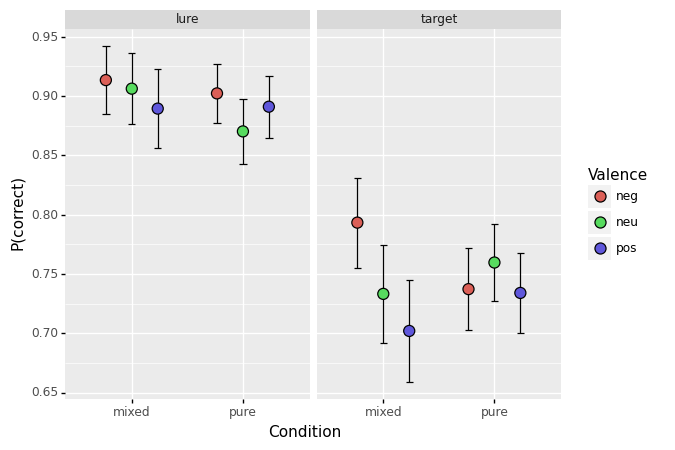

<ggplot: (8769086017934)>

In [7]:
p = (pn.ggplot(res, pn.aes('cond', 'mean', fill='valence'))
     + pn.geom_errorbar(pn.aes(ymin='mean-ci', ymax='mean+ci', width=0.2), 
                        position=pn.position_dodge(.7))
     + pn.geom_point(position=pn.position_dodge(.7), size=4)
     + pn.facet_wrap('~novelty')
     + pn.labs(x="Condition", y = "P(correct)", fill='Valence')
    )
p

## Testing for significance

Using a standard linear model, we must average performance within subject


In [8]:
# use the agg method to get the means
perf = df_w.groupby(['subj', 'cond', 'valence', 'novelty'])['correct'].mean()
perf = perf.reset_index()
perf

,subj,cond,valence,novelty,correct
0,s000,mixed,neg,lure,0.968750
1,s000,mixed,neg,target,1.000000
2,s000,mixed,neu,lure,0.937500
3,s000,mixed,neu,target,0.843750
4,s000,mixed,pos,lure,0.843750
...,...,...,...,...,...
151,s012,pure,neg,target,0.687500
152,s012,pure,neu,lure,0.708333
153,s012,pure,neu,target,0.625000
154,s012,pure,pos,lure,0.812500


In [9]:
# build a linear regression of the full model
m0 = smf.ols("correct ~ cond * valence * novelty", perf).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                correct   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     3.714
Date:                Thu, 18 Nov 2021   Prob (F-statistic):           0.000113
Time:                        07:22:32   Log-Likelihood:                 75.812
No. Observations:                 156   AIC:                            -127.6
Df Residuals:                     144   BIC:                            -91.03
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         0.9135      0.043     21.261      0.000       0.829       0.998
cond[T.pure]                                     -0.0112      0.061     -0.185      0.854      -0.131       0.109
valence[T.neu]                                   -0.0072      0.061     -0.119      0.906      -0.127       0.113
valence[T.pos]                                   -0.0240      0.061     -0.396      0.693      -0.144       0.096
novelty[T.target]                                -0.1202      0.061     -1.978      0.050      -0.240   -9.23e-05
cond[T.pure]:valence[T.neu]                      -0.0248      0.086     -0.289      0.773      -0.195       0.145
cond[T.pure]:valence[T.pos]                       0.0128      0.086      0.149      0.882      -0.157       0.183
cond[T.pure]:novelty[T.target]                   -0.0449      0.086     -0.522      0.602      -0.215       0.125
valence[T.neu]:novelty[T.target]                 -0.0529      0.086     -0.615      0.539      -0.223       0.117
valence[T.pos]:novelty[T.target]                 -0.0673      0.086     -0.783      0.435      -0.237       0.103
cond[T.pure]:valence[T.neu]:novelty[T.target]     0.1074      0.122      0.884      0.378      -0.133       0.348
cond[T.pure]:valence[T.pos]:novelty[T.target]     0.0753      0.122      0.620      0.536      -0.165       0.316
==============================================================================
Omnibus:                       17.457   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.694
Skew:                          -0.835   Prob(JB):                     5.29e-05
Kurtosis:                       3.491   Cond. No.                         25.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Running an ANOVA on the linear model results

- Such a complicated linear model is really hard to unpack
- The most common approach to modeling the data would be a repeated measures ANOVA
- Luckily, a linear regression is really just an ANOVA if you make the right comparisons
- Statsmodels provides a way to handle that for you.

In [10]:
# Run a type-II repeated measures ANOVA based on the linear model results
sm.stats.anova_lm(m0, typ=2)

,sum_sq,df,F,PR(>F)
cond,0.002028,1.0,0.084518,7.716844e-01
valence,0.027694,2.0,0.577016,5.628648e-01
novelty,0.903946,1.0,37.667746,7.709695e-09
cond:valence,0.016677,2.0,0.347461,7.070699e-01
cond:novelty,0.002504,1.0,0.104343,7.471477e-01
valence:novelty,0.007829,2.0,0.163123,8.496438e-01
cond:valence:novelty,0.019748,2.0,0.411458,6.634597e-01
Residual,3.455696,144.0,NaN,NaN


- Looks like a big effect of novelty (target vs. lure), but not much else.
- This isn't a huge surprise from that graph

## So what's the problem?

- If you average data within subject, what happened to the within-subject variability in performance?
  - It's gone!
- It could be that the entire effect is driven by item outliers (see Clark, 1993)

## An item effect

* Some average subject data

| Subject | Cond 1 | Cond 2 |
| :- | -: | -: |
| Pat | 400ms | 500ms
| Sam  | 420ms | 530ms
| Robin | 380ms | 490ms


* Some average item data

| Item | Cond 1 | Cond 2 |
| :- | -: | -: |
| chicken | 390ms  | 395ms |
| octopus | 410ms  | **1100ms** |
| horse |   380ms  | 400ms |


* The effect is driven by a single item, "octopus"!

* This is why it's now common practice to include both subject and
  item analyses.


## Subjects and Items

- What if you could account for subject and item-level variability
  *at the same time*?

- Mixed effects models allow just that, and you get all that and more!
  You can include:

  - Continuous dependent and independent variables.

  - Interactions between any combo of continuous and discrete
    variables.


- This means we can analyze the actual valence values instead of the groups!
- You are also working with the raw data instead of summary statistics!

## Mixed Effects

* Split your model into **random** and **fixed** effects.

* For **random** effects we expect random variation across that
  variable (e.g., subjects, items, etc...)

* For **fixed** effects you expect systematic changes between
  conditions (i.e. your experimental manipulations).


# Bayesian models

- As mentioned in a previous class, it is possible to build models of the world out of probability distributions.
- The process involves:
  - Determining the correct probability distribution function for your observed data
  - Then finding the parameters of that function to maximize the probability of observing your data

## Visualizing the fitting process

Say we have some data, can we figure out what model and parameters could have generated those data?

In [11]:
data = np.array([3.39317851, 0.92986704, 2.6072234 , 1.63686968, 2.69860129,
                 2.3531901 , 2.67225635, 1.93437793, 2.0751784 , 3.71950222,
                 1.39434613, 2.37011522, 0.81351156, 2.36217543, 3.30390727,
                 2.78832169, 2.11905216, 1.48325417, 0.73556411, 2.36148697])

Text(0.5, 1.0, 'Log Likelihood: -37.429')

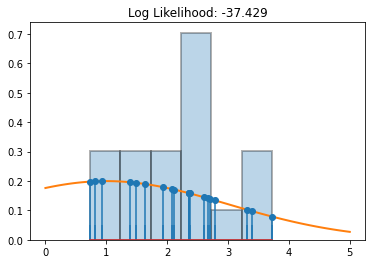

In [41]:
# let's start by visulizing our data
plt.hist(data, bins='auto', alpha=.3, lw=2, edgecolor='k', density=True);
plt.vlines(data, ymin=0, ymax=0.05)

# adjust the mean (mu) and standard deviation (sigma) to maximize the log likelihood
mu = 1.0
sigma = 2.0
xvals = np.linspace(0, 5, 100)
d = dists.norm(loc=mu, scale=sigma)
plt.plot(xvals, d.pdf(xvals), lw=2)
plt.stem(data, d.pdf(data))
plt.title('Log Likelihood: %.3f' % np.log(d.pdf(data)).sum())

## Maximum Likelihood

We can calculate parameters that maximize the likelihood of observing the data given the model and those parameters:

$$\hat{L} = P(D \mid \hat{\theta}, M)$$

However, this approach ignores the fact that there are many parameter values that *could* have generated the same data.


## Bayesian Inference

Instead, what we'd really like to know is the full set of possible parameters given the data:

$$P(\theta \mid D)$$

This should look familiar and a probability reminder should give a hint for how to calculate it...

## Basics of Probability



### A   
$P(A) \in [0, 1]$

### not A
$1 - P(A)$

### A or B 
$P(A \cup B) = P(A) + P(B) - P(A \cap B)$ or <br> $P(A \cup B) = P(A) + P(B)$ if A and B are mutually exclusive

### A and B
$P(A \cap B) = P(A \mid B) P(B) = P(B \mid A) P(A)$ or <br> $P(A \cap B) = P(A) P(B)$ if A and B are independent

### A given B 
$P(A \mid B) = \frac{P(A \cap B)}{P(B)} = \frac{P(B \mid A) P(A)}{P(B)}$






## Bayes Rule

$$P(\theta \mid D) = \frac{P(\theta \cap D)}{P(D)} = \frac{P(D \mid \theta) P(\theta)}{P(D)} \propto P(D \mid \theta) P(\theta)$$

- $P(\theta \mid D)$ is the posterior probability
- $P(D \mid \theta)$ is the likelihood
- $P(\theta)$ is the prior probability
- $P(D)$ is the marginal likelihood (*does not depend on model or params*)

## What's a prior?

A prior probability represents the initial belief in the potential values of some quantity before any new evidence is taken into account.

The notion of a prior is one of the key differences between Bayesian and Frequentist approaches. Bayesians believe that we should take such prior knowledge into account when making decisions and that this prior knowledge can be updated with each new bit of evidence:

"Today's posterior is tomorrow's prior"

That said, priors are also a major critique of Bayesian approaches because they can have a massive effect on the posterior (i.e., the conclusions you draw).

## Bayesian Inference

Determining $P(\theta \mid D)$ can be difficult for a number of reasons:

- The likelihood $P(D \mid \theta)$ is often intractable, requiring simulation
- Can be unfeasible/impossible to determine the marginal likelihood ($P(D)$)

The standard approach is to use Markov chain Monte Carlo (MCMC) to estimate the posterior.


# Bayesian Mixed-effects Regression

- We can use hierarchical Bayesian approaches to build regression models that predict trial-level data taking   into account both subject-level and item-level variability.

- The *BAyesian Model-Building Interface ([Bambi](https://bambinos.github.io/bambi/index.html))* package helps us build and perform parameter inference on mixed-effects models.


## Treating valence as continuous

/home/per/anaconda3/envs/smile/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 18'. Pick better value with 'binwidth'.


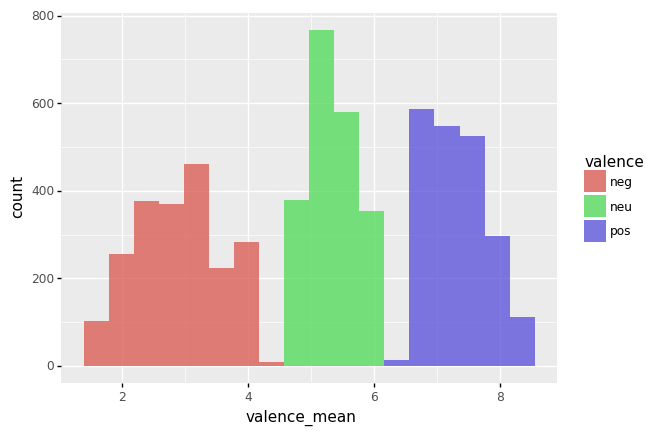

<ggplot: (8768994925439)>

In [16]:
# Show the distributions of valence values
p = (pn.ggplot(df_w, pn.aes('valence_mean', fill='valence'))
     + pn.geom_histogram(alpha=.8)
    )
p

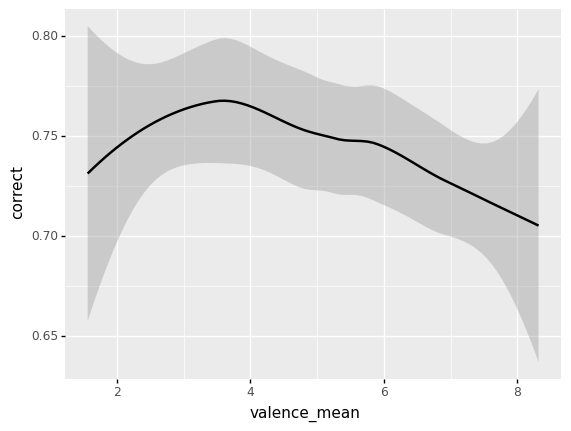

<ggplot: (8769004185269)>

In [18]:
p = (pn.ggplot(df_w.loc[df_w['novelty']=='target'], pn.aes('valence_mean', 'correct'))
     + pn.geom_smooth(method='loess')
    )
p

## Build and fit the model

In [22]:
# First initialize the model with the data frame we're using
model = bmb.Model('correct ~ cond * valence_mean + (1|subj) + (1|description)', 
                  df_w.loc[df_w['novelty']=='target'],
                  family='bernoulli')

# next build the regression with both fixed and random effects
results = model.fit()

Modeling the probability that correct==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [1|description_offset, 1|description_sigma, 1|subj_offset, 1|subj_sigma, Intercept, cond:valence_mean, valence_mean, cond]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 158 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


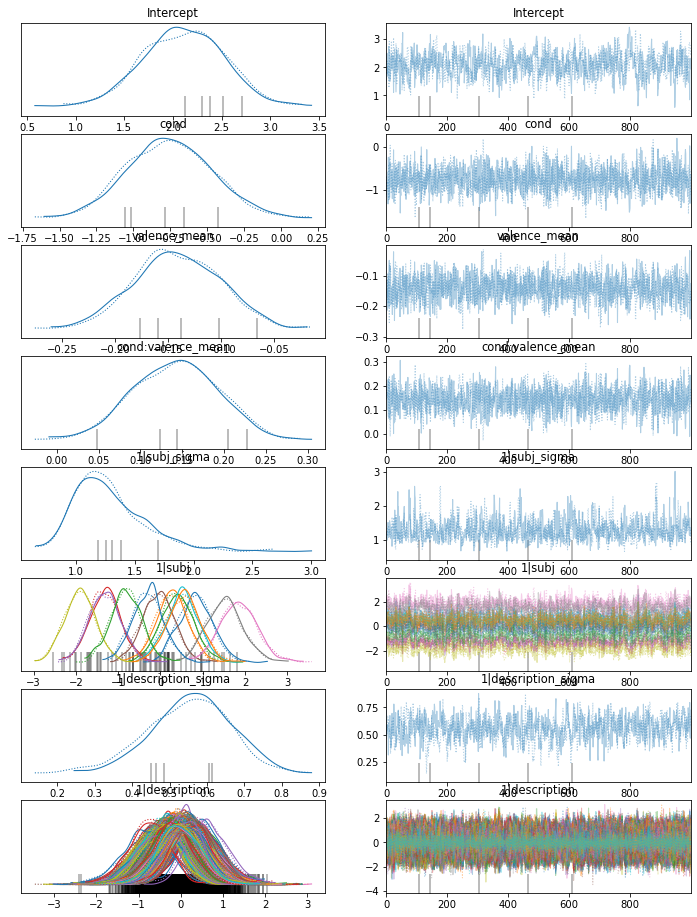

In [23]:
# plot the inference traces for the fit
az.plot_trace(results, compact=True);

In [25]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.108,0.423,1.350,2.916,0.018,0.013,530.0,674.0,1.0
cond[pure],-0.754,0.286,-1.249,-0.183,0.007,0.005,1792.0,1583.0,1.0
valence_mean,-0.141,0.041,-0.214,-0.064,0.001,0.001,1694.0,1520.0,1.0
cond:valence_mean[pure],0.142,0.051,0.042,0.229,0.001,0.001,1743.0,1582.0,1.0
1|subj_sigma,1.285,0.311,0.778,1.871,0.012,0.008,768.0,816.0,1.0
...,...,...,...,...,...,...,...,...,...
1|description[writer],-0.070,0.496,-1.069,0.806,0.008,0.012,3408.0,1399.0,1.0
1|description[yacht],-0.114,0.512,-1.118,0.802,0.008,0.013,3677.0,1334.0,1.0
1|description[yellow],-0.100,0.561,-1.127,0.994,0.011,0.016,2908.0,1008.0,1.0
1|description[young],-0.016,0.526,-1.080,0.895,0.007,0.015,5579.0,1151.0,1.0


## Significance involves evaluating the posteriors

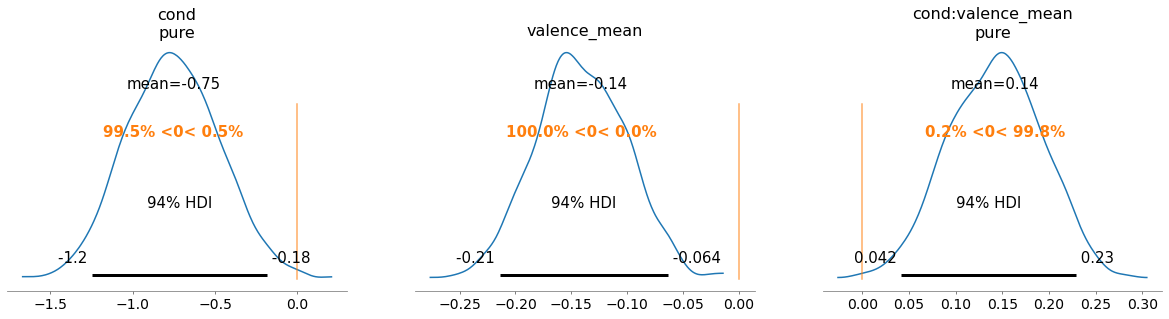

In [24]:
# plot the fixed effect posteriors to examine significance
az.plot_posterior(results, ref_val=0.0, var_names=['cond', 'valence_mean', 'cond:valence_mean']);

## Perform model comparison to determine what parameters to keep

- Not all the parameters of the model help with the fit
- We can perform Bayesian model comparison to identify the simplest model that best captures the data

In [26]:
# next build the regression without the item random effect
res_noitem = bmb.Model('correct ~ cond * valence_mean + (1|subj)', 
                  df_w.loc[df_w['novelty']=='target'],
                  family='bernoulli').fit()

Modeling the probability that correct==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [1|subj_offset, 1|subj_sigma, Intercept, cond:valence_mean, valence_mean, cond]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 89 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [27]:
# next build the regression without the interaction
res_nointer = bmb.Model('correct ~ cond + valence_mean + (1|subj)', 
                  df_w.loc[df_w['novelty']=='target'],
                  family='bernoulli').fit()

Modeling the probability that correct==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [1|subj_offset, 1|subj_sigma, Intercept, valence_mean, cond]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [29]:
# next build the regression with only valence
res_valence = bmb.Model('correct ~ valence_mean + (1|subj)', 
                  df_w.loc[df_w['novelty']=='target'],
                  family='bernoulli').fit()

Modeling the probability that correct==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [1|subj_offset, 1|subj_sigma, Intercept, valence_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [30]:
# next build the regression with only cond
res_cond = bmb.Model('correct ~ cond + (1|subj)', 
                  df_w.loc[df_w['novelty']=='target'],
                  family='bernoulli').fit()

Modeling the probability that correct==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [1|subj_offset, 1|subj_sigma, Intercept, cond]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 32 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


## Compare the models

- The model with the fewest parameters that is not significantly worse than the other models is the best to keep.

In [31]:
cres = az.compare({'full':results, 'noitem': res_noitem, 
                   'noint':res_nointer, 'cond': res_cond, 'valence': res_valence})
cres

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
full,0,-1518.376882,132.424064,0.000000,0.902305,29.970725,0.000000,False,log
noitem,1,-1528.006078,15.669923,9.629196,0.000000,29.754711,4.577099,False,log
valence,2,-1529.934058,13.923952,11.557176,0.063686,29.760580,5.367164,False,log
noint,3,-1530.755959,14.767239,12.379077,0.000000,29.791278,5.366644,False,log
cond,4,-1532.032747,13.759221,13.655865,0.034010,29.699465,5.757571,False,log


<AxesSubplot:xlabel='Log'>

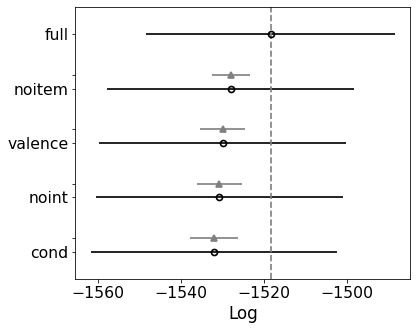

In [32]:
az.plot_compare(cres, insample_dev=False)

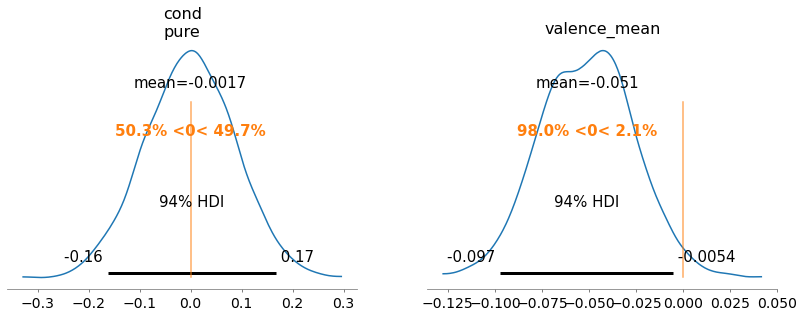

In [33]:
# show how evaluating the incorrect model can affect results
az.plot_posterior(res_nointer, ref_val=0.0, var_names=['cond', 'valence_mean']);

## Conclusion

- There seem to be effects of both condition and valence value on whether or not participants got targets correct.
- Many more analyses to do!!!

# Have a great Thanksgiving break!!!

- Your Free Recall assignment is due Sunday.
- We'll discuss the final project upon our return.
